In [63]:
import tensorflow as tf
import numpy as np
import pandas as pd , sys
import matplotlib.pyplot as plt
import scikitplot as skplt
from IPython.display import clear_output
from sklearn.metrics import auc , roc_auc_score
sys.path.append("/home/advice/Python/SR/Custom/")
from RAdam import RAdamOptimizer
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


In [64]:
import skopt
print(skopt.__version__)
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

0.5.2


In [65]:
from tensorflow.contrib.layers import *
def get_weight_variable(shape, name=None,
                        type='xavier_uniform', regularize=True, **kwargs):
    initialise_from_constant = False
    if type == 'xavier_uniform':
        initial = xavier_initializer(uniform=True, dtype=tf.float32)
    elif type == 'xavier_normal':
        initial = xavier_initializer(uniform=False, dtype=tf.float32)
    elif type == 'he_normal':
        initial = variance_scaling_initializer(uniform=False, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'he_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'caffe_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=1.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'simple':
        stddev = kwargs.get('stddev', 0.02)
        initial = tf.truncated_normal(shape, stddev=stddev, dtype=tf.float32)
        initialise_from_constant = True
    elif type == 'bilinear':
        weights = _bilinear_upsample_weights(shape)
        initial = tf.constant(weights, shape=shape, dtype=tf.float32)
        initialise_from_constant = True
    else:
        raise ValueError('Unknown initialisation requested: %s' % type)

    if name is None:  # This keeps to option open to use unnamed Variables
        weight = tf.Variable(initial)
    else:
        if initialise_from_constant:
            weight = tf.get_variable(name, initializer=initial)
        else:
            weight = tf.get_variable(name, shape=shape, initializer=initial)
    if regularize:
        tf.add_to_collection('weight_variables', weight)
    return weight 

In [66]:
data = pd.read_csv("./../Data/income_evaluation.csv")
objcol = data.select_dtypes("object").columns.tolist()
data[objcol] = data[objcol].astype("category")
data.columns = [i.strip() for i in data.columns.tolist()]

In [67]:
data["income"] = data["income"].cat.codes
target = data.pop("income")
num_col = data.select_dtypes("int").columns.tolist()
cat_col = data.select_dtypes("category").columns.tolist()
onehot_data = pd.get_dummies(data , columns= cat_col)

In [68]:
from sklearn.model_selection import train_test_split
Train_X , Test_X , Train_y , Test_y = train_test_split(onehot_data , 
                                                         target , test_size = 0.3)

In [69]:
one_hot_var = Train_X.columns.tolist()
in_var = data.columns.tolist()

In [70]:
def OneHotIndex(in_var , num_var , one_hot_var) :
    start_idx = 0
    key_store = {}
    store = []
    for idx , col in enumerate(in_var) :
        if col in num_var :
            aa = [start_idx , start_idx +1]
            store.append(aa)
            start_idx += 1
        else :
            find = [idx for idx , ck in enumerate(one_hot_var) if re.search("^{}_".format(col) , ck)]
            nn = len(find)
            aa = [start_idx , start_idx + nn]
            start_idx += nn
            store.append(aa)
        key_store[col] = aa
    return key_store , store

In [71]:
import re
key_onehot_store , onehot_store = OneHotIndex(in_var , num_col , one_hot_var)
Train_y.reset_index(drop=True ,inplace=True)
target_1_list = Train_y[(Train_y == 1) == True].index.tolist()
target_0_list = Train_y[(Train_y == 0) == True].index.tolist()

In [72]:
ck = list(set(target_1_list) & set(target_0_list))
assert ck == [], "중복 발생 : {}".format(ck)

In [73]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

numeric_features = num_col 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
clf = Pipeline(steps=[('preprocessor', preprocessor),])
clf.fit(Train_X)
Train_X[num_col] = clf.transform(Train_X)
#Valid_X[num_col] = clf.transform(Valid_X)
Test_X[num_col] = clf.transform(Test_X)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/root/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [74]:
Train_X_np = Train_X.values
#Valid_X_np = Valid_X.values
Test_X_np = Test_X.values
print(in_var)

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


In [75]:
def variable_select(in_var = None , method = None , select_n = None , NTree = None) :
    var_n = len(in_var)
    if method== "sqrt" :
        value =np.sqrt(var_n)
    elif method == "log2" :
        value =np.log2(var_n)
    elif method == "select" :
        value = select_n
    else :
        value = var_n
    return [list(np.random.choice(in_var ,
                                  replace = False , 
                                  size = value)) for _ in range(NTree)]
select_var = variable_select(in_var=in_var , method="select" , 
                               select_n= 10 , NTree= 5)
print(select_var)

[['education', 'race', 'capital-loss', 'hours-per-week', 'capital-gain', 'age', 'education-num', 'native-country', 'occupation', 'sex'], ['capital-gain', 'native-country', 'relationship', 'workclass', 'marital-status', 'hours-per-week', 'sex', 'capital-loss', 'occupation', 'education'], ['occupation', 'workclass', 'education', 'native-country', 'marital-status', 'fnlwgt', 'relationship', 'hours-per-week', 'capital-gain', 'education-num'], ['sex', 'capital-loss', 'workclass', 'fnlwgt', 'occupation', 'race', 'native-country', 'relationship', 'capital-gain', 'education'], ['education', 'capital-gain', 'workclass', 'capital-loss', 'relationship', 'fnlwgt', 'age', 'hours-per-week', 'education-num', 'occupation']]


## 앙상블 테스트

In [ ]:
def tf_mish(x) :
    act = x * tf.nn.tanh(tf.nn.softplus(x))
    return act

In [ ]:
activate_candidate = \
[tf.nn.selu, tf_mish , tf.nn.leaky_relu , tf.nn.elu ]

## SKOPT 알고리즘

In [ ]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learning_rate')
dim_activation = Categorical(categories=activate_candidate,
                             name='activation')

dense_layers_1 = Integer(low=2, high=5, name='dense_layers_1')
dense_nodes_1 = Integer(low=10, high=28, name='dense_nodes_1')
dense_layers_2 = Integer(low=2, high=5, name='dense_layers_2')
dense_nodes_2 = Integer(low=10, high=28, name='dense_nodes_2')
dense_layers_3 = Integer(low=2, high=5, name='dense_layers_3')
dense_nodes_3 = Integer(low=10, high=28, name='dense_nodes_3')
dense_layers_4 = Integer(low=2, high=5, name='dense_layers_4')
dense_nodes_4 = Integer(low=10, high=28, name='dense_nodes_4')
dense_layers_5 = Integer(low=2, high=5, name='dense_layers_5')
dense_nodes_5 = Integer(low=10, high=28, name='dense_nodes_5')
default_parameters = [1e-5, tf.nn.selu , 
                      3,15, 
                      3,15, 
                      4,10,
                      3,25,
                      3,20,
                     ]
dimensions = [
    dim_learning_rate ,
    dim_activation,
    dense_layers_1,
    dense_nodes_1,
    dense_layers_2,
    dense_nodes_2,
    dense_layers_3,
    dense_nodes_3,
    dense_layers_4,
    dense_nodes_4,
    dense_layers_5,
    dense_nodes_5,
             ]

def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       activation)

    return log_dir

In [ ]:
Train_X_np.shape

(22792, 108)

In [ ]:
def Classifier(Nensemble = select_var ,
               learning_rate=None , activation=None,
               dense_layers_1 = None , dense_nodes_1 =None , 
               dense_layers_2 = None , dense_nodes_2 =None , 
               dense_layers_3 = None , dense_nodes_3 =None , 
               dense_layers_4 = None , dense_nodes_4 =None , 
               dense_layers_5 = None , dense_nodes_5 =None , ) :

    Ensembles = []
    target_n = 2 
    hidden = [
        [dense_nodes_1] * dense_layers_1 + [target_n] , 
        [dense_nodes_2] * dense_layers_2 + [target_n] ,
        [dense_nodes_3] * dense_layers_3 + [target_n] ,
        [dense_nodes_4] * dense_layers_4 + [target_n] ,
        [dense_nodes_5] * dense_layers_5 + [target_n]
    ]
    init_candidate =\
    ["xavier_uniform","xavier_normal", 
     "he_normal", "he_uniform","caffe_uniform"]
    row , dim = Train_X_np.shape
    target_n = 2 
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = [ None , dim],name="X")
    y = tf.placeholder(tf.float32, shape = [ None , 1], name="y")
    DropoutRate = tf.placeholder(tf.float32, name ="dropoutRate")
    training = tf.placeholder_with_default(False, shape=[], name="training")
    with tf.variable_scope("Ensembles"):
        for idx , __vars__ in enumerate(Nensemble) :
            x_input = []
            for key in __vars__ :
                start_node , terminal_node = key_onehot_store[key]
                diff = terminal_node - start_node
                X_Split = tf.slice(X , [0, start_node] , [-1 , diff])
                x_input.append(X_Split)
            x_input = tf.concat(x_input , axis = 1)
            TOTAL_DIM = x_input.get_shape().as_list()[1]
#             SELECT = np.random.randint(0 , len(activate_candidate) , 1)[0]
            SELECT2 = np.random.randint(0 , len(init_candidate) , 1)[0]
#             activation = activate_candidate[SELECT]
            init = init_candidate[SELECT2]
            dims = hidden[idx]
            dims = [TOTAL_DIM] + dims
            print(dims)
            for idx2 , h_dim in enumerate(dims) :
                if idx2 == 0 :
                    Weight =get_weight_variable(shape = [TOTAL_DIM , h_dim], 
                                                name="W_{}{}".format(idx , idx2),
                                                type=init, regularize=True)
                    Bias = tf.get_variable("Bias_{}{}".format(idx , idx2),
                                           shape = [h_dim] , dtype = tf.float32 , 
                                           initializer = tf.constant_initializer(0.0))
                    Layer = tf.matmul( x_input , Weight) + Bias
                    Layer = activation(Layer)
                    Weight =get_weight_variable(shape = [TOTAL_DIM , 10], 
                                                name="Info_W_{}{}".format(idx , idx2),
                                                type=init, regularize=True)
                    InfoLayer = tf.matmul( x_input , Weight)
                    Layer = tf.contrib.nn.alpha_dropout(Layer , DropoutRate ) 
                else :
                    if idx2 == 1 : h_n = dims[idx2-1] + 10
                    else : h_n = dims[idx2-1]
                    Weight =get_weight_variable(shape = [h_n ,h_dim ], 
                                                name="W_{}{}".format(idx , idx2),
                                                type=init, regularize=True)
                    Bias = tf.get_variable("Bias_{}{}".format(idx , idx2),
                                           shape = [h_dim] , dtype = tf.float32 , 
                                           initializer = tf.constant_initializer(0.0))
                    if idx2 == 1 : Layer = tf.concat([Layer, InfoLayer], axis = 1)
                    else : pass
                    Layer = tf.matmul( Layer , Weight) + Bias
                    if len(dims) == idx2+1 : 
                        pass
                    else : 
                        Layer = activation(Layer)
                        Layer = tf.contrib.nn.alpha_dropout(Layer , DropoutRate ) 
            Ensembles.append(Layer)
            
        NModels = Ensembles
        y_one_hot =\
        tf.one_hot( 
            tf.cast(
                tf.squeeze(y , axis = 1 ) , tf.int32) , depth= target_n)
        
        y_weight_info = compute_class_weight(class_weight= "balanced" , 
                             classes = np.unique(target),
                             y= np.squeeze(target))
        weight = tf.constant([ y_weight_info[1] ] ) # 
        mod = sys.modules[__name__]
        for idx , Model in enumerate(NModels) :
            setattr(mod, 'model_{}_softmax'.format(idx), 
                    tf.argmax( tf.nn.softmax(Model) , axis = 1 ))
        Loss = []
        Probs = 0
        for idx , Model in enumerate(NModels) :
            loss = tf.nn.weighted_cross_entropy_with_logits(targets = y_one_hot ,
                                                             logits = Model , 
                                                             pos_weight = weight)
            Probs +=tf.nn.softmax(Model)
            Loss.append(loss)
            #Loss += loss
        Loss = tf.reduce_mean(Loss)
        #Loss /= len(NModels)
        Probs = tf.nn.softmax(Probs)
        vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Ensembles")
        L2 = []
        WEIGHTS = []
        import re 
        for v in vars :
            if re.search('W_' , v.name) :
                WEIGHTS.append(v)
                L2.append(tf.nn.l2_loss(v))
        Loss += tf.add_n(L2)  * 0.1
        l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, 
                                                          scope=None)
        regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, 
                                                                        WEIGHTS )
        Loss += regularization_penalty
        solver = RAdamOptimizer(learning_rate= learning_rate).minimize(Loss ,var_list = vars )
        return [Ensembles , Probs , Loss , solver , 
                X , y , DropoutRate , training]

In [ ]:
best_auc = 0.0

In [ ]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate=None , activation=None,
                  dense_layers_1 = None , dense_nodes_1 =None , 
                  dense_layers_2 = None , dense_nodes_2 =None , 
                  dense_layers_3 = None , dense_nodes_3 =None , 
                  dense_layers_4 = None , dense_nodes_4 =None , 
                  dense_layers_5 = None , dense_nodes_5 =None):
    
    Lists = Classifier(Nensemble= select_var ,
                         learning_rate=learning_rate , 
                         activation=activation,
                         dense_layers_1 = dense_layers_1 ,
                         dense_nodes_1 = dense_nodes_1 , 
                         dense_layers_2 = dense_layers_2 ,
                         dense_nodes_2 =dense_nodes_2 , 
                         dense_layers_3 = dense_layers_3 ,
                         dense_nodes_3 =dense_nodes_3 , 
                         dense_layers_4 = dense_layers_4 ,
                         dense_nodes_4 =dense_nodes_4 , 
                         dense_layers_5 = dense_layers_5 ,
                         dense_nodes_5 =dense_nodes_5)
    (NModels , Probs ,
     Loss , solver,
     X , y ,
     DropoutRate , training) = Lists
    Epoch = 200
    mb_size = 1000
    config=tf.ConfigProto(log_device_placement=True)
    config.gpu_options.allow_growth = True
    sess = tf.Session(config = config)
    sess.run(tf.global_variables_initializer())
    _Loss_ = []
    _Epoch_ = []
    _Epoch2_ = [0]
    _trAUC_ , _teAUC_ = [0] , [0]
    for epoch in range(Epoch) :
        print(epoch , end = "\r")
        target1 = np.random.choice(target_1_list ,
                                   int(len(target_1_list)/2) ,
                                   replace = False )
        target0 = np.random.choice(target_0_list , 
                                   len(target_0_list) ,
                                   replace = True )
        target1 = list(target1)
        target0 = list(target0)
        if epoch > 10 :
            target1 = target1 + 2 * checkpoint 
        XX = Train_X_np[target1 + target0  , : ]
        YY = Train_y.values[target1 + target0]
        idx = np.random.permutation(len(XX))
        XX = XX[idx , : ]
        YY = YY[idx]
        batch_iter = int(len(XX) / mb_size)
        batchLoss = 0
        for idx in range(batch_iter) :
            X_mb = XX[idx*mb_size:(idx+1)*mb_size]
            Y_mb = YY[idx*mb_size:(idx+1)*mb_size]
            Feed = {X : X_mb ,
                    y : Y_mb.reshape(-1,1) , 
                    DropoutRate : 0.5 ,
                    training : True }
            _ , LOSS  = sess.run([solver , Loss] , feed_dict= Feed)
            batchLoss += LOSS
        batchLoss /= batch_iter
        _Loss_.append(batchLoss)
        _Epoch_.append(epoch)

        if epoch % 10 == 0 :
            Feed = {X : Train_X_np  ,
                    DropoutRate : 1.0 ,
                    training : True }
            probs  = sess.run(Probs , feed_dict= Feed)
            real_target = np.squeeze(Train_y.values)
            pred_target = np.argmax(probs,axis =1)
            AUC = roc_auc_score(real_target , probs[:,1])
            DD = pd.DataFrame([real_target ,pred_target], index = ["t","p"]).T
            DD2 = DD[(DD.t == 1) & (DD.p==0)]
            checkpoint = DD2.index.tolist()
    
    
    Feed = {X : Train_X_np  ,
            DropoutRate : 1.0 ,
            training : True }
    
    probs  = sess.run(Probs , feed_dict= Feed)
    real_target = np.squeeze(Train_y.values)
    pred_target = np.argmax(probs,axis =1)
    AUC = roc_auc_score(real_target , probs[:,1])
    
    global best_auc
    if best_auc < AUC :
        print("="*10)
        print("{} < {}".format(best_auc ,AUC))
        print("="*10)
        best_auc= AUC
    tf.reset_default_graph()
    clear_output()
    return -AUC

In [ ]:
import skopt

In [ ]:
gp_result = gp_minimize(func=fitness,
                        dimensions=dimensions,
                        n_calls= 10,
                        acq_func='EI',
                        n_random_starts  = 5 , 
                        noise= 0.01,
                        n_jobs= -1,
                        kappa = 1,
                        x0=default_parameters)

## [skopt 저장해두고 쓰는 법](https://scikit-optimize.github.io/notebooks/interruptible-optimization.html)

In [ ]:
x0 = gp_result.x_iters
y0 = gp_result.func_vals
gp_result = gp_minimize(func=fitness,
                        dimensions=dimensions,
                        x0 = x0,
                        y0 = y0 ,
                        n_calls= 100,
                        acq_func='EI',
                        noise= 0.01,
                        n_jobs=-1,
                        kappa = 5)

[85, 16, 16, 16, 2]
[100, 21, 21, 21, 21, 2]
[99, 13, 13, 13, 13, 13, 2]
[98, 12, 12, 2]
[52, 10, 10, 10, 2]
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: TITAN X (Pascal), pci bus id: 0000:04:00.0, compute capability: 6.1



In [93]:
len(gp_result.func_vals)

110

In [94]:
#gp_result

In [95]:
#pd.DataFrame(gp_result.x_iters)
list_of_lists = [[f"nodes{i}" , f"layer{i}"] for i in range(1,6)]
layer_node = [y for x in list_of_lists for y in x]

In [96]:
Result = pd.DataFrame(gp_result.x_iters, 
                      columns=["lr", "activation"] + layer_node)
Result["activation"] = Result["activation"].apply(lambda x : x.__name__)
Result["AUC"] = -gp_result.func_vals

In [97]:
Result.sort_values(["AUC"],ascending=False).to_csv("skopt_result.csv", index=False)

In [100]:
Result.sort_values(["AUC"],ascending=False)

,lr,activation,nodes1,layer1,nodes2,layer2,nodes3,layer3,nodes4,layer4,nodes5,layer5,AUC
35,0.000005,elu,2,10,4,26,5,19,4,15,4,10,0.772994
64,0.000014,leaky_relu,2,14,2,27,2,12,5,27,4,10,0.744567
34,0.000001,selu,2,11,3,13,2,23,3,25,5,10,0.735782
107,0.000001,tf_mish,3,20,4,27,3,17,2,13,3,18,0.684456
69,0.000047,elu,5,17,4,17,2,12,5,10,2,10,0.679902
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.000033,selu,2,23,3,11,5,13,3,27,2,28,0.344389
93,0.000001,elu,2,24,5,25,2,26,3,27,5,28,0.332766
50,0.000063,elu,3,10,4,11,4,28,5,11,3,10,0.312848
24,0.000006,elu,5,28,4,13,5,28,5,28,5,25,0.297578


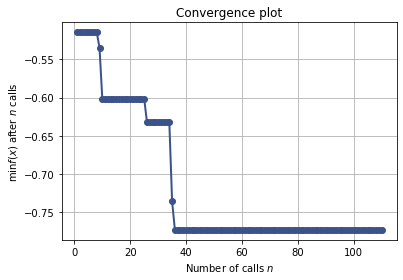

In [99]:
from skopt.plots import plot_convergence
plot_convergence(gp_result);